# Introduction aux arbres de décision

Comme étudié dans la feuille de TD2, les arbres de décisions structurent un ensemble de règles de décisions sous la forme d'un arbre. Dans ce TP, nous allons utiliser des algorithmes d'apprentissage d'arbres de décision sur des données réelles et étudier leur capacité à prédire la classe de nouvelles données. Cette étude nous permettra d'appréhender le concept d'**over-fitting**.

## A. Préparation du dataset

Le dataset `breast-cancer.data` comporte la description de près de 300 patientes atteintes d'un cancer du sein et examinées dans un institut d'oncologie en Slovénie. La tâche consiste à prédire le risque de récidive pour la patiente à partir des 9 descripteurs catégoriels suivants :

|  Type  |    Catégorie    |
| :---------:|---------|
| age | âge de la patiente|
| menopause | statut ménopausal |
| tumor-size | taille de la tumeur|
| inv-nodes | nombre de ganglions invasifs |
| node-caps | capsule ganglionnaire |
| deg-malig | Degré de malignité |
| breast | sein (gauche ou droit) |
| breast-quad | quadrant mammaire |
| irradiat | radiothérapie |

Chargez le dataset dans un dataframe `patient` et vérifiez les données récupérées (taille, valeurs manquantes, nature des descripteurs, déséquilibre des classes, etc.)

In [221]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

patient = pd.read_csv('donnees/breast-cancer.data')

print("taille du dataframe:", patient.shape)
print("Valeurs manquantes:\n", patient.isnull().sum())
print("Nature:\n", patient.dtypes)
print("Classes:\n", patient['class'].value_counts())


taille du dataframe: (286, 10)
Valeurs manquantes:
 class          0
age            0
menopause      0
tumor-size     0
inv-nodes      0
node-caps      0
deg-malig      0
breast         0
breast-quad    0
irradiat       0
dtype: int64
Nature:
 class          object
age            object
menopause      object
tumor-size     object
inv-nodes      object
node-caps      object
deg-malig       int64
breast         object
breast-quad    object
irradiat       object
dtype: object
Classes:
 class
no-recurrence-events    201
recurrence-events        85
Name: count, dtype: int64


Procédez à l'extraction des descriptions et des labels de classes dans deux tableaux Numpy :
- `X` pour la matrice des descriptions (286 x 9)
- `y` pour le vecteur des labels de classes

In [222]:
X = patient.iloc[:, 1:].values
y = patient.iloc[:, 0].values

print("X:", X.shape)
print("y:", y.shape)

X: (286, 9)
y: (286,)


## B. One-hot encoding

Utilisez le [`OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) de Scikit-learn pour transformer votre matrice `X` en une matrice binaire `Xbin` où une variable catégorielle initiale avec $k$ modalités sera décomposée en $k$ variables binaires.

In [223]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
encoder.fit(X)
Xbin = encoder.transform(X)

Observez la forme de la matrice récupérée (nombre de variables) et le type particulier de cette matrice. Documentez-vous. 

In [224]:
print(Xbin.shape)
print(type(Xbin))
Xbin.todense()

(286, 43)
<class 'scipy.sparse._csr.csr_matrix'>


matrix([[0., 1., 0., ..., 0., 1., 0.],
        [0., 0., 1., ..., 1., 1., 0.],
        [0., 0., 1., ..., 0., 1., 0.],
        ...,
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 1., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 1., 0.]])

Vérfiez la transformation opérée sur la première variable catégorielle `age` :
- observez le nombre $k$ de modalités (valeurs) pour cette variable
- vérifiez que chaque ligne de `Xbin` contient exactement une composante à 1 (et toutes les autres à 0) sur les $k$ premières composantes

In [225]:
print(np.unique(X[:,0]))
sum(Xbin[:,:6].sum(axis=1)!=1)

['20-29' '30-39' '40-49' '50-59' '60-69' '70-79']


matrix([[0]])

## C. Apprentissage d'un arbre de décision

Utilisez la librairie Scikit-learn pour découper `Xbin` (et `y`) en deux sous-ensembles (`X_train`, `y_train`) et (`X_test`, `y_test`). On procèdera pour ce TP à un découpage en sous-ensembles de mêmes tailles (50/50).

In [226]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(Xbin, y, test_size=0.5, random_state=0)

print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

X_train: (143, 43)
X_test: (143, 43)
y_train: (143,)
y_test: (143,)


> <br/>Scikit-learn propose une implémentation assez générique des arbres de décision. Le constructeur d'un [`DecisionTreeClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier) permet de paramétrer la méthode d'apprentissage ainsi que certaines propriétés attendues sur la structure de l'arbre. Notamment :
> - le paramètre `criterion` definit la mesure de qualité utilisée pour le découpage : `'gini'` (par défaut), `'entropy'` (vu en TD) ou `'log_loss'`
> - le paramètre `min_sample_leaf` definit le nombre minimum d'individus autorisés dans les feuilles de l'arbre (1 par défaut) <br/><br/>
>
> Un arbre de décision (`DecisionTreeClassifier`) peut ensuite être manipulé à partir de deux méthodes :
> - `.fit(X, y)` qui permet d'apprendre un arbre de décision à partir d'un dataset d'entraînement `(X, y)` où <br/> <br/>
>   - `X` contient des descriptions (numériques ou binaires)
>   - `y` contient les labels de classes associés.<br/> <br/>
> - `.predict(X)` qui permet de prédire la classe de chaque individu du dataset `X` <br/>  <br/>

Apprendre un arbre de décision sur les données d'entraînement en utilisant l'entropie comme critère de découpage et en conservant les propriétés structurelles par défaut. Stockez votre modèle de prédiction (arbre de décision) dans une variable `dtree`. 

In [227]:
from sklearn import tree

dtree = tree.DecisionTreeClassifier(criterion='entropy')
dtree = dtree.fit(X_train, y_train)

y_pred = dtree.predict(X_test)

La commande suivante vous offre une visualisation du modèle appris.

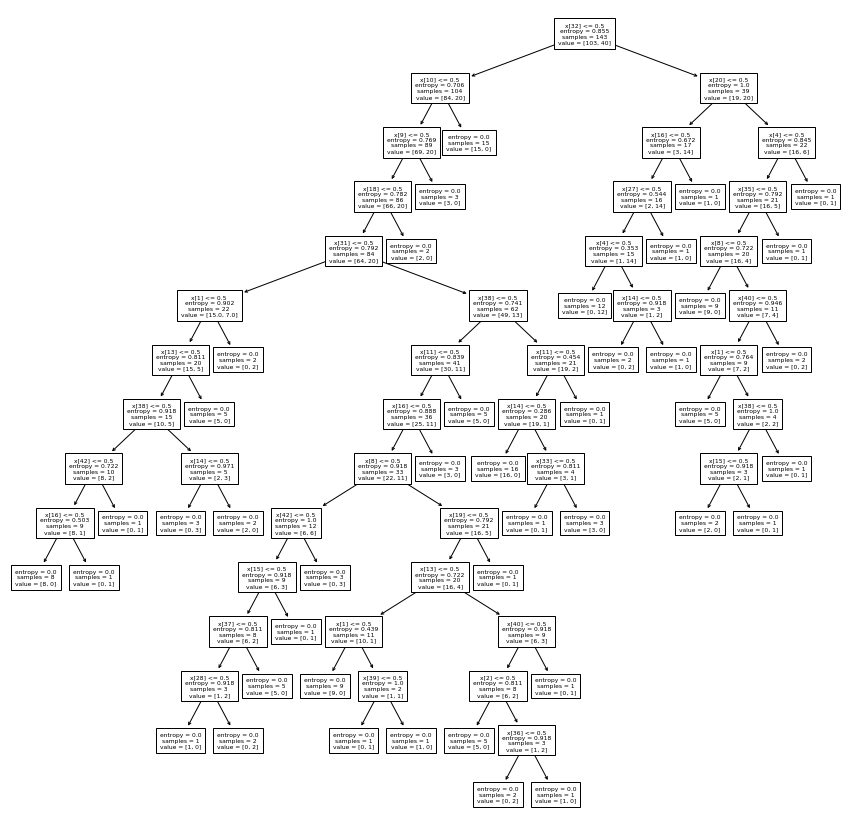

In [228]:
plt.figure(figsize=(15,15))
tree.plot_tree(dtree, fontsize=6)
plt.show()

Utilisez les paramètres de votre `OneHotEncoder` pour donner du sens aux descripteurs utilisés dans les noeuds de l'arbre de décision :
- l'attribut `categories_` décrit les nouvelles variables binaires construites à partir de chaque variables catégorielle initiale
- la méthode `.get_feature_names_out()` retourne la liste de toutes les variables binaires

In [229]:
print(encoder.get_feature_names_out())
print(encoder.categories_)

['x0_20-29' 'x0_30-39' 'x0_40-49' 'x0_50-59' 'x0_60-69' 'x0_70-79'
 'x1_ge40' 'x1_lt40' 'x1_premeno' 'x2_0-4' 'x2_10-14' 'x2_15-19'
 'x2_20-24' 'x2_25-29' 'x2_30-34' 'x2_35-39' 'x2_40-44' 'x2_45-49'
 'x2_5-9' 'x2_50-54' 'x3_0-2' 'x3_12-14' 'x3_15-17' 'x3_24-26' 'x3_3-5'
 'x3_6-8' 'x3_9-11' 'x4_?' 'x4_no' 'x4_yes' 'x5_1' 'x5_2' 'x5_3' 'x6_left'
 'x6_right' 'x7_?' 'x7_central' 'x7_left_low' 'x7_left_up' 'x7_right_low'
 'x7_right_up' 'x8_no' 'x8_yes']
[array(['20-29', '30-39', '40-49', '50-59', '60-69', '70-79'], dtype=object), array(['ge40', 'lt40', 'premeno'], dtype=object), array(['0-4', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39',
       '40-44', '45-49', '5-9', '50-54'], dtype=object), array(['0-2', '12-14', '15-17', '24-26', '3-5', '6-8', '9-11'],
      dtype=object), array(['?', 'no', 'yes'], dtype=object), array([1, 2, 3], dtype=object), array(['left', 'right'], dtype=object), array(['?', 'central', 'left_low', 'left_up', 'right_low', 'right_up'],
      dtype=object), arr

Observez quelques propriétés structurelles de l'arbre de décision :
- nombre de feuilles (sont-elles toutes pures?)
- profondeur de l'arbre 

Vérifiez ces propriétés en utilisant les attributs de votre objet `dtree` (`.get_n_leaves()`, `.get_depth()`)

In [230]:
dtree.get_n_leaves(), dtree.get_depth()

(42, 14)

## D. Over-fitting

Calculez et comparer les taux d'erreurs de prédiction sur :
- les données d'entraînement `X_train` qui ont servi à construire l'arbre de décision
- les données de test `X_test` qui n'ont jamais été utilisées

In [231]:
train_error = 1 - dtree.score(X_train, y_train)
test_error = 1 - dtree.score(X_test, y_test)

print("Taux d'erreur d'apprentissage:", train_error)
print("Taux d'erreur de test:", test_error)


Taux d'erreur d'apprentissage: 0.0
Taux d'erreur de test: 0.32167832167832167


Comment expliquez-vous cette différence?

L'arbre de décision appris a pu découper exactement les données d'entraînement de sorte à ce qu'il sache les classer parfaitement. Cependant, les nouvelles données ne se conforment pas exactement aux données de test. L'arbre de décision appris est trop spécifique aux données d'entraînement et ne généralise pas bien sur de nouvelles données.

Apprenez un nouvel arbre de décision moins profond à partir de `X_train` toujours (par exemple avec `min_sample_leaf=5`). Observez ses propriétés structurelles puis ses performances (taux d'erreur sur `X_train` puis sur `X_test`).

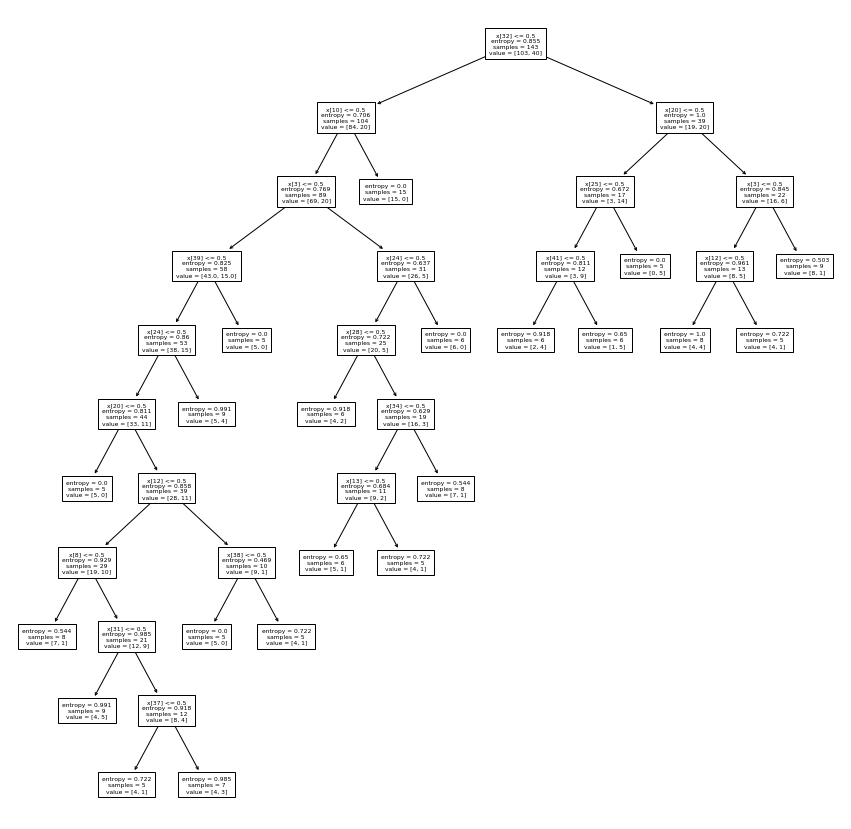

Taux d'erreur d'apprentissage: 0.19580419580419584
Taux d'erreur de test: 0.3076923076923077


In [232]:
dtree2 = tree.DecisionTreeClassifier(criterion='entropy', min_samples_leaf=5)
dtree2 = dtree2.fit(X_train, y_train)

y_pred = dtree2.predict(X_test)

plt.figure(figsize=(15,15))
tree.plot_tree(dtree2, fontsize=6)
plt.show()

train_error = 1 - dtree2.score(X_train, y_train)
test_error = 1 - dtree2.score(X_test, y_test)

print("Taux d'erreur d'apprentissage:", train_error)
print("Taux d'erreur de test:", test_error)

> On parle d'<font color='red'>over-fitting</font> (sur-adéquation aux données) lorsqu'un modèle $f$ appris est très performant sur les données utilisées pour l'apprentissage mais n'ai pas suffisamment générique pour prédire sur de nouvelles données (données de test).
> Pour détecter l'over-fitting on compare :
> - l'<font color='red'>erreur d'apprentissage</font> $e_{train}(f)$: taux d'erreur sur les données d'entraînement (`X_train`)
> - l'<font color='red'>erreur de généralisation</font> $e_{test}(f)$: taux d'erreur sur les données de test (`X_test`)
>
> Le modèle $f$ est sujet à over-fitting si $e_{test}(f) \gg e_{train}(f)$
> <br><br>

> Une manière de réduire l'over-fitting des arbres de décision consiste à limiter la taille des règles de décision (et donc la profondeur de l'arbre) :
> - des règles de décision trop longues ont peu de chance d'être satisfaites par de nouveaux exemples (règles trop spécifiques)
> - des règles de décision courtes ont plus de chance d'être satisfaite par de nouveaux exemples (règles plus générales) <br/><br/>

Ecrire un fonction `eval_DT(X_train, y_train, X_test, y_test, min_samples_leaf)` qui retourne l'erreur d'apprentissage et l'erreur de généralisation d'un arbre de décision de profonduer contrôlée par `min_samples_leaf`, appris sur `X_train` et testé sur `X_test`.

In [233]:
def eval_DT(X_train, y_train, X_test, y_test, min_samples_leaf):
    dtree = tree.DecisionTreeClassifier(criterion='entropy', min_samples_leaf=min_samples_leaf)
    dtree = dtree.fit(X_train, y_train)
    train_error = 1 - dtree.score(X_train, y_train)
    test_error = 1 - dtree.score(X_test, y_test)
    return train_error, test_error

Etudiez le phénomène d'over-fitting sur les données `breast-cancer`. Pour cela :
- calculez les erreurs d'apprentissage et de généralisation en faisant évoluer la profondeur de l'arbre (ex. `min_samples_leaf` variant de 1 à 50)
- tracez les courbes associées

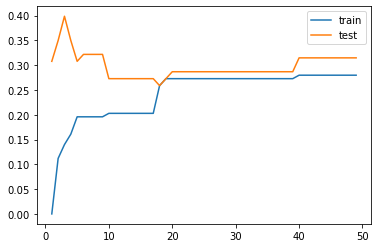

In [234]:
train_error = []
test_error = []
for i in range(1, 50):
    te, ve = eval_DT(X_train, y_train, X_test, y_test, i)
    train_error.append(te)
    test_error.append(ve)

plt.plot(range(1, 50), train_error, label='train')
plt.plot(range(1, 50), test_error, label='test')
plt.legend()
plt.show()

Ré-executez votre notebook pour voir dans quelle mesure le phénomène d'over-fitting est sensible au (découpage du) dataset. Faites également évoluer la proportion d'exemples utilisés pour apprendre l'arbre de décision.